In [4]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn openpyxl ftfy deep-translator imblearn 



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [6]:
# Load dataset and do initial inspection

df = pd.read_excel('Triage_Dataset.xlsx')
print('Loaded dataset with shape:', df.shape)

display(df.head())
print('Dtypes:', df.dtypes)

print("\nColumns:") 
print(df.columns.tolist())

print('Numeric summary:')
display(df.describe(include=[np.number]).transpose())

print('Missing values per column:')
print(df.isna().sum())

print('Duplicate rows:', df.duplicated().sum())

Loaded dataset with shape: (1267, 24)


,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71.0,3,3,2,right ocular pain,1,1,2.0,...,36.6,100,2,Corneal abrasion,1,4,2,86.0,5.000000,1
1,1,1,56.0,12,3,2,right forearm burn,1,1,2.0,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64.0,3.950000,1
2,2,1,67.5,8,2,2,"arm pain, Lt",1,1,2.0,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862.0,1.000000,1
3,1,2,71.0,8,1,1,ascites tapping,1,1,3.0,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108.0,9.833333,1
4,1,2,58.0,4,3,1,"distension, abd",1,1,3.0,...,36.5,NaN,4,Ascites,1,5,8,109.0,6.600000,1


Dtypes: Group                         int64
Sex                           int64
Age                         float64
Patients number per hour      int64
Arrival mode                  int64
Injury                        int64
Chief_complain               object
Mental                        int64
Pain                          int64
NRS_pain                    float64
SBP                          object
DBP                          object
HR                           object
RR                           object
BT                           object
Saturation                   object
KTAS_RN                       int64
Diagnosis in ED              object
Disposition                   int64
KTAS_expert                   int64
Error_group                   int64
Length of stay_min          float64
KTAS duration_min           float64
mistriage                     int64
dtype: object

Columns:
['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Chief_complain', 'Mental'

,count,mean,std,min,25%,50%,75%,max
Group,1267.0,1.456985,0.498343,1.000000,1.0,1.000000,2.0,2.00000
Sex,1267.0,1.521705,0.499726,1.000000,1.0,2.000000,2.0,2.00000
Age,1267.0,54.394396,19.722260,15.500000,37.0,57.000000,71.0,95.80000
Patients number per hour,1267.0,7.519337,3.160563,1.000000,5.0,7.000000,10.0,17.00000
Arrival mode,1267.0,2.820837,0.807904,1.000000,2.0,3.000000,3.0,7.00000
Injury,1267.0,1.192581,0.394482,1.000000,1.0,1.000000,1.0,2.00000
Mental,1267.0,1.105762,0.447768,1.000000,1.0,1.000000,1.0,4.00000
Pain,1267.0,0.563536,0.496143,0.000000,0.0,1.000000,1.0,1.00000
NRS_pain,711.0,4.104079,1.419332,1.000000,3.0,4.000000,5.0,10.00000
KTAS_RN,1267.0,3.335438,0.885391,1.000000,3.0,3.000000,4.0,5.00000


Missing values per column:
Group                         0
Sex                           0
Age                           0
Patients number per hour      0
Arrival mode                  0
Injury                        0
Chief_complain                0
Mental                        0
Pain                          0
NRS_pain                    556
SBP                           0
DBP                           0
HR                            0
RR                            0
BT                            0
Saturation                  688
KTAS_RN                       0
Diagnosis in ED               2
Disposition                   0
KTAS_expert                   0
Error_group                   0
Length of stay_min            0
KTAS duration_min             0
mistriage                     0
dtype: int64
Duplicate rows: 0


In [7]:
import re

hangul_re = re.compile(r'[\uac00-\ud7a3]')

df_clean = df.copy()

mask = df_clean.astype(str).apply(lambda col: col.str.contains(hangul_re, na=False)).any(axis=1)
count = mask.sum()

if count > 0:
    hangul_df = df_clean[mask].copy()
    hangul_df.to_excel('rows_with_hangul.xlsx', index=False)
    df_clean = df_clean[~mask].reset_index(drop=True)
    df_clean.to_excel('cleaned.xlsx', index=False)
    print(f'Found {count} rows with Hangul. Files saved.')
else:
    print('No Hangul detected; cleaned file unchanged.')


Found 58 rows with Hangul. Files saved.


In [8]:
df_clean = pd.read_excel('cleaned.xlsx')

num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    med = df_clean[c].median()
    df_clean[c] = df_clean[c].fillna(med)
    nonnull = df_clean[c].dropna()
    try:
        if not nonnull.empty and np.all(np.equal(np.mod(nonnull.astype(float), 1), 0)):
            df_clean[c] = df_clean[c].astype('Int64')
    except Exception:
        pass

obj_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
for c in obj_cols:
    if df_clean[c].isna().any():
        modes = df_clean[c].mode(dropna=True)
        if not modes.empty:
            df_clean[c] = df_clean[c].fillna(modes[0])

int_cols = ["Age", "NRS_pain", "SBP", "DBP", "RR", "Saturation"]
for col in int_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

        df_clean[col] = df_clean[col].round().astype("Int64")

df_clean["BT"] = ( df_clean["BT"] .astype(str) .str.replace(r'[^0-9.\-]', '', regex=True) .replace("", np.nan) .astype(float) )

print('Dtypes after reading cleaned file:')
print(df_clean.dtypes)

df_clean.to_excel('cleaned.xlsx', index=False)
print('Saved cleaned file to cleaned.xlsx')


Dtypes after reading cleaned file:
Group                         Int64
Sex                           Int64
Age                           Int64
Patients number per hour      Int64
Arrival mode                  Int64
Injury                        Int64
Chief_complain               object
Mental                        Int64
Pain                          Int64
NRS_pain                      Int64
SBP                           Int64
DBP                           Int64
HR                            Int64
RR                            Int64
BT                          float64
Saturation                    Int64
KTAS_RN                       Int64
Diagnosis in ED              object
Disposition                   Int64
KTAS_expert                   Int64
Error_group                   Int64
Length of stay_min          float64
KTAS duration_min           float64
mistriage                     Int64
dtype: object
Saved cleaned file to cleaned.xlsx


In [9]:
duplicates = df_clean.duplicated().sum()
if duplicates > 0:
    print(f"Found {duplicates} duplicate rows. Removing them...")
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)
else:
    print("No duplicate rows found.")

# Normalize column names
df_clean.columns = (
    df_clean.columns
    .str.strip()              
    .str.lower()               
    .str.replace(' ', '_')      
    .str.replace(r'[^\w_]', '', regex=True) 
)

# Numeric columns (excluding BT)
numeric_cols = ["Age", "NRS_pain", "SBP", "DBP", "HR", "RR", "Saturation"]
for col in numeric_cols:
    if col in df_clean.columns:
        print(f"\nColumn: {col}")
        print(df_clean[col].describe())
        if col == "Age":
            df_clean.loc[(df_clean[col] < 0) | (df_clean[col] > 120), col] = np.nan
        elif col in ["SBP"]:
            df_clean.loc[(df_clean[col] < 50) | (df_clean[col] > 250), col] = np.nan
        elif col in ["DBP"]:
            df_clean.loc[(df_clean[col] < 30) | (df_clean[col] > 150), col] = np.nan
        elif col in ["HR"]:
            df_clean.loc[(df_clean[col] < 30) | (df_clean[col] > 200), col] = np.nan
        elif col in ["RR"]:
            df_clean.loc[(df_clean[col] < 5) | (df_clean[col] > 60), col] = np.nan
        elif col in ["Saturation"]:
            df_clean.loc[(df_clean[col] < 50) | (df_clean[col] > 100), col] = np.nan

# Handle BT separately as float
if "BT" in df_clean.columns:
    df_clean.loc[(df_clean["BT"] < 30) | (df_clean["BT"] > 45), "BT"] = np.nan

text_cols = ["Chief_complain", "Diagnosis in ED"]
for col in text_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.lower().str.strip()

# Fill missing numeric values and convert to integers (except BT)
for col in numeric_cols:
    if col not in df_clean.columns:
        continue
    if df_clean[col].isna().any():
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
    df_clean[col] = df_clean[col].round()
    df_clean[col] = df_clean[col].astype("Int64")

# Fill missing BT values but keep as float
if "BT" in df_clean.columns and df_clean["BT"].isna().any():
    median_bt = df_clean["BT"].median()
    df_clean["BT"] = df_clean["BT"].fillna(median_bt)

# Fill missing text values
for col in text_cols:
    if col in df_clean.columns:
        mode_val = df_clean[col].mode(dropna=True)
        if not mode_val.empty:
            df_clean[col] = df_clean[col].fillna(mode_val[0])

# Age groups
df_clean["age_group"] = pd.cut(df_clean["age"], bins=[0,12,18,40,60,120], labels=["child","teen","adult","middle","senior"])

# Vitals flags
df_clean["tachycardia"] = (df_clean["hr"]>100).astype(int)
df_clean["bradycardia"] = (df_clean["hr"]<60).astype(int)
df_clean["hypertension"] = (df_clean["sbp"]>140).astype(int)
df_clean["hypotension"] = (df_clean["sbp"]<90).astype(int)
df_clean["hypoxia"] = (df_clean["saturation"]<92).astype(int)
df_clean["fever"] = (df_clean["bt"]>37.5).astype(int)
df_clean["hypothermia"] = (df_clean["bt"]<35).astype(int)
df_clean["tachypnea"] = (df_clean["rr"]>20).astype(int)
df_clean["bradypnea"] = (df_clean["rr"]<12).astype(int)

# Save cleaned file
df_clean.to_excel('cleaned_final.xlsx', index=False)
print("Saved fully cleaned dataset to 'cleaned_final.xlsx'")

print("\nRemaining missing values per column:")
print(df_clean.isna().sum())
print("\nFinal dtypes:")
print(df_clean.dtypes)


No duplicate rows found.
Saved fully cleaned dataset to 'cleaned_final.xlsx'

Remaining missing values per column:
group                       0
sex                         0
age                         0
patients_number_per_hour    0
arrival_mode                0
injury                      0
chief_complain              0
mental                      0
pain                        0
nrs_pain                    0
sbp                         0
dbp                         0
hr                          0
rr                          0
bt                          0
saturation                  0
ktas_rn                     0
diagnosis_in_ed             0
disposition                 0
ktas_expert                 0
error_group                 0
length_of_stay_min          0
ktas_duration_min           0
mistriage                   0
age_group                   0
tachycardia                 0
bradycardia                 0
hypertension                0
hypotension                 0
hypoxia        

Dataset shape: (1209, 34)

Columns: ['group', 'sex', 'age', 'patients_number_per_hour', 'arrival_mode', 'injury', 'chief_complain', 'mental', 'pain', 'nrs_pain', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation', 'ktas_rn', 'diagnosis_in_ed', 'disposition', 'ktas_expert', 'error_group', 'length_of_stay_min', 'ktas_duration_min', 'mistriage', 'age_group', 'tachycardia', 'bradycardia', 'hypertension', 'hypotension', 'hypoxia', 'fever', 'hypothermia', 'tachypnea', 'bradypnea']

Data types:
group                         int64
sex                           int64
age                           int64
patients_number_per_hour      int64
arrival_mode                  int64
injury                        int64
chief_complain               object
mental                        int64
pain                          int64
nrs_pain                      int64
sbp                           int64
dbp                           int64
hr                            int64
rr                            int64
bt       

,count,mean,std,min,25%,50%,75%,max
group,1209.0,1.464020,0.498910,1.000000,1.0,1.000000,2.0,2.00000
sex,1209.0,1.522746,0.499689,1.000000,1.0,2.000000,2.0,2.00000
age,1209.0,54.194376,19.820538,16.000000,37.0,56.000000,71.0,96.00000
patients_number_per_hour,1209.0,7.488834,3.137851,1.000000,5.0,7.000000,10.0,17.00000
arrival_mode,1209.0,2.820513,0.810757,1.000000,2.0,3.000000,3.0,7.00000
injury,1209.0,1.193548,0.395242,1.000000,1.0,1.000000,1.0,2.00000
mental,1209.0,1.067825,0.326072,1.000000,1.0,1.000000,1.0,4.00000
pain,1209.0,0.574028,0.494694,0.000000,0.0,1.000000,1.0,1.00000
nrs_pain,1209.0,4.068652,1.073963,1.000000,3.0,4.000000,4.0,10.00000
sbp,1209.0,133.965261,26.896148,65.000000,114.0,130.000000,150.0,275.00000


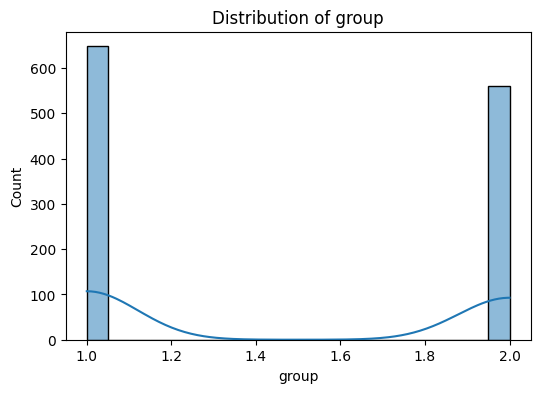

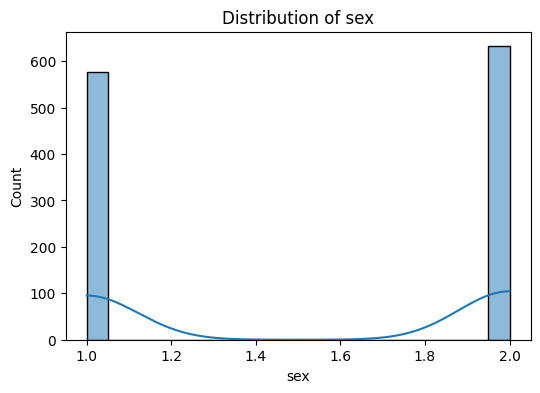

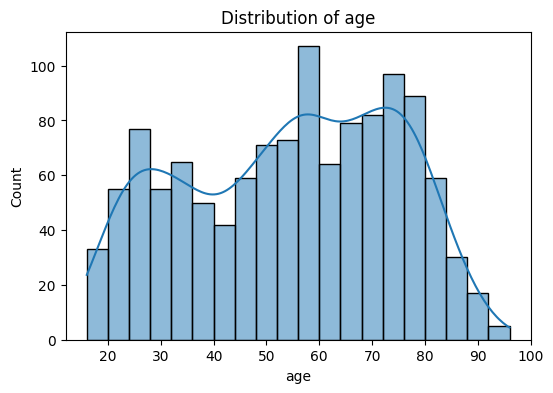

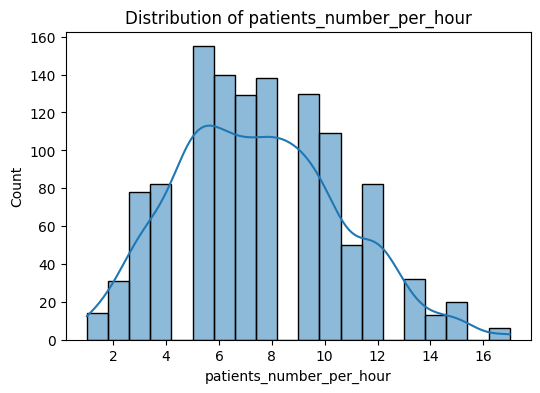

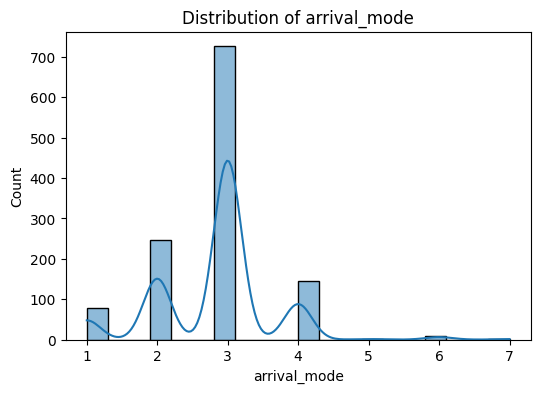

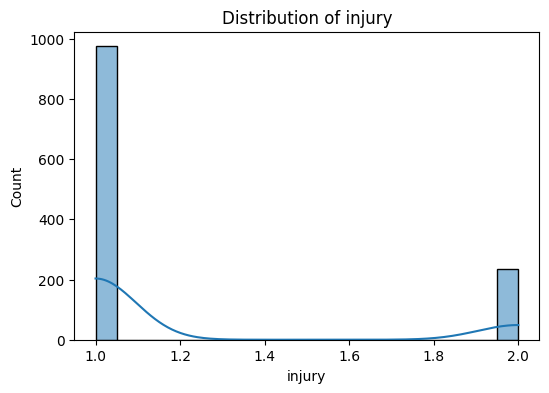

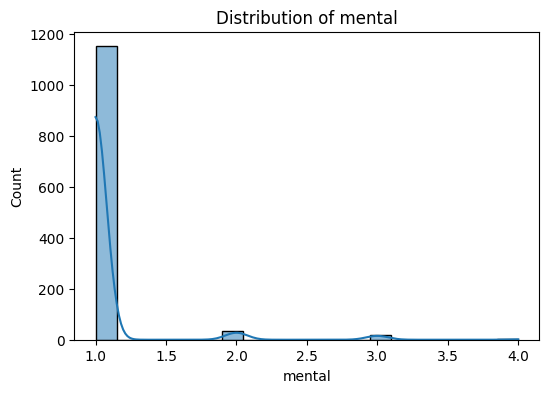

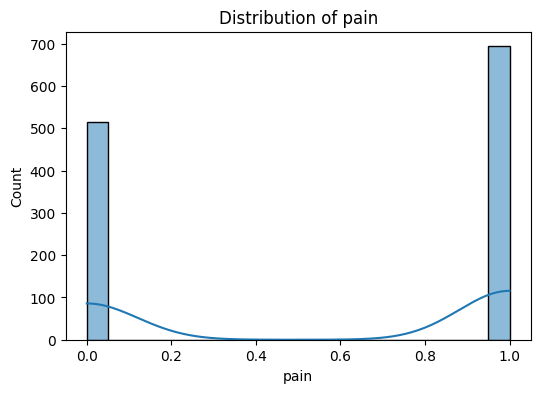

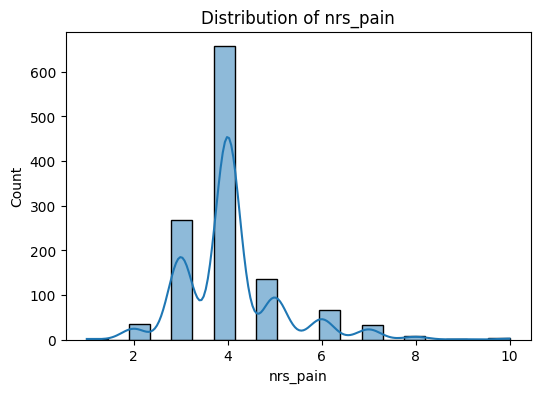

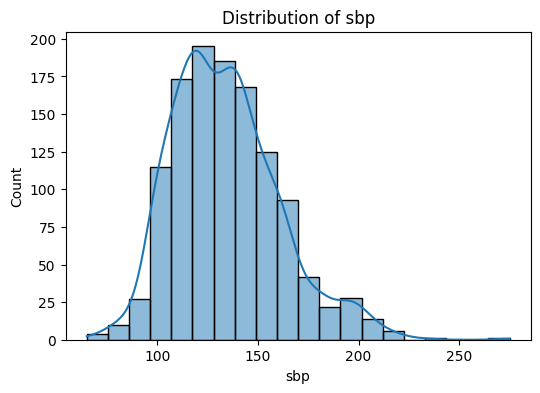

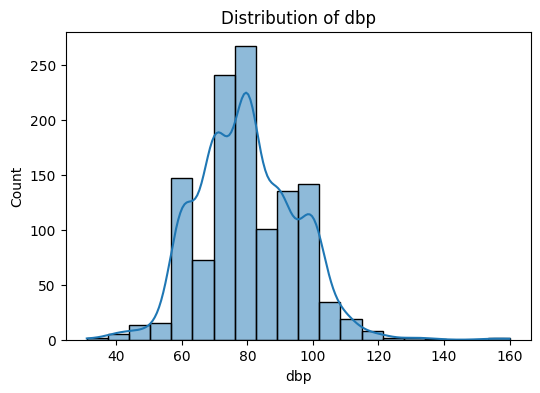

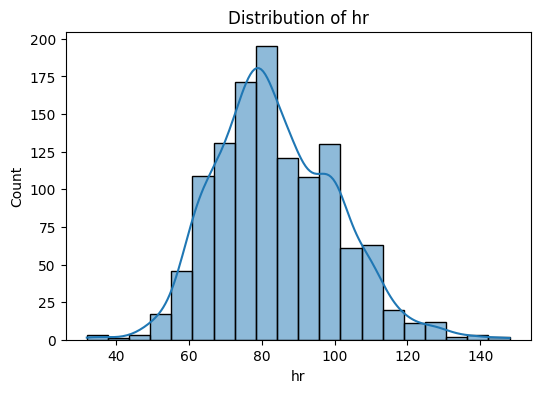

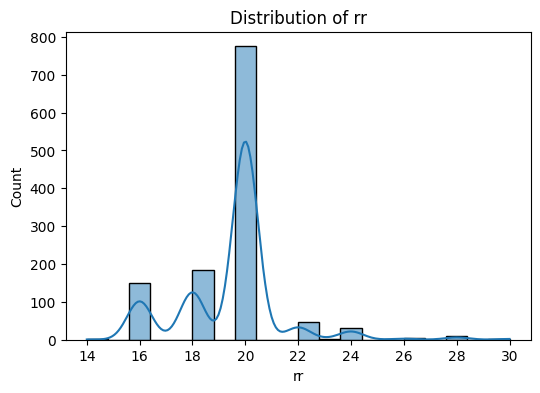

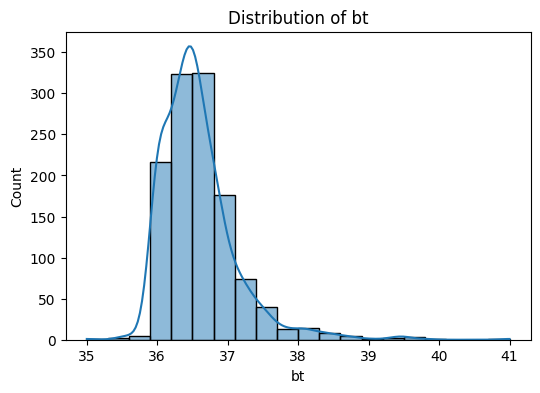

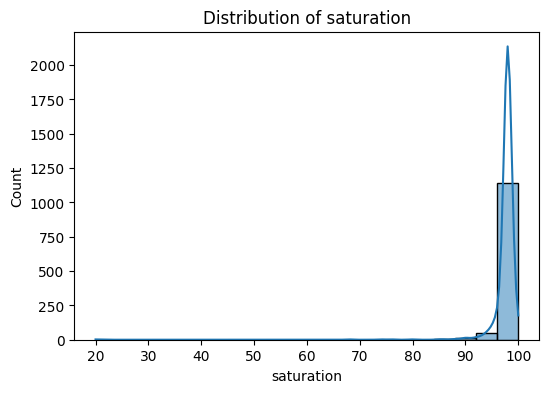

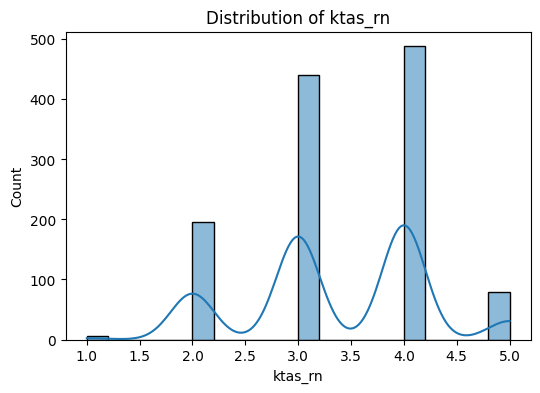

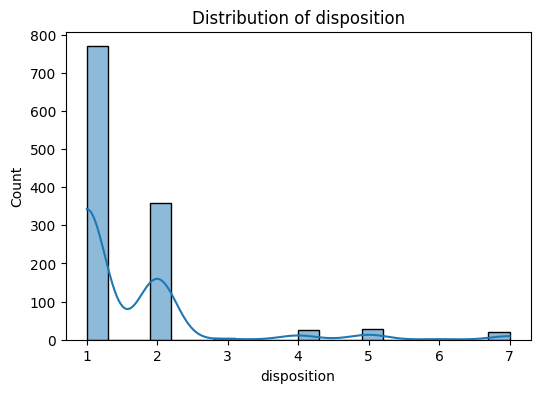

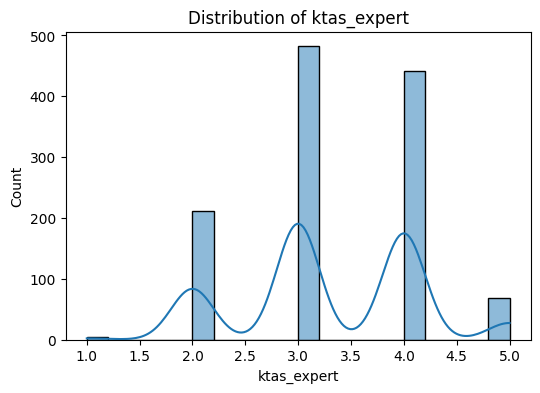

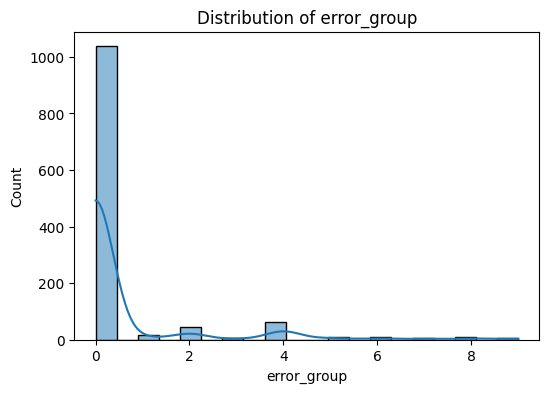

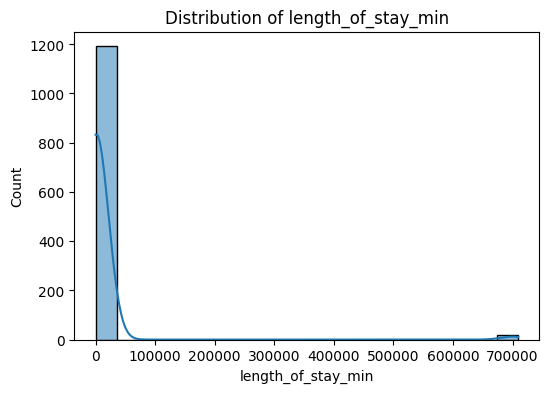

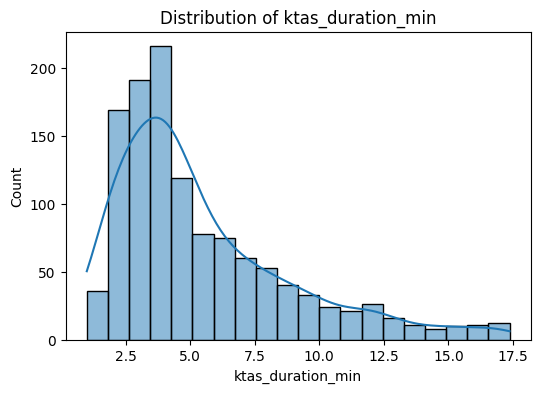

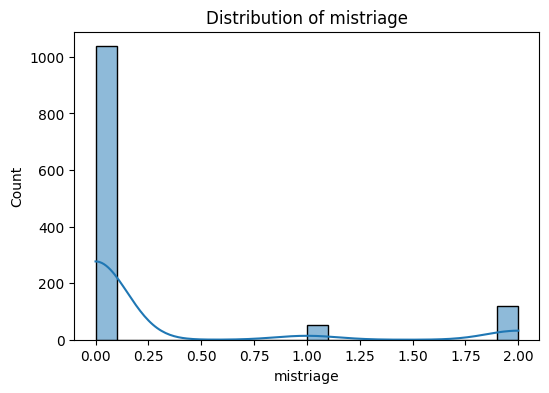

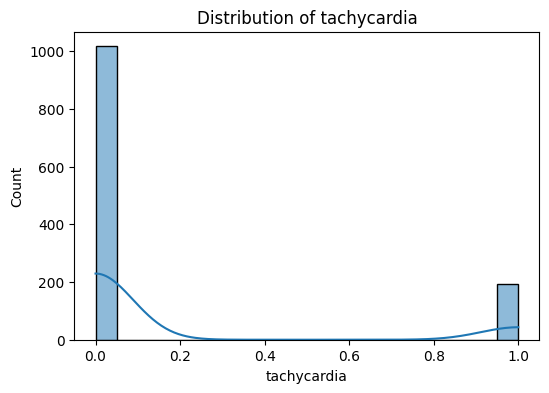

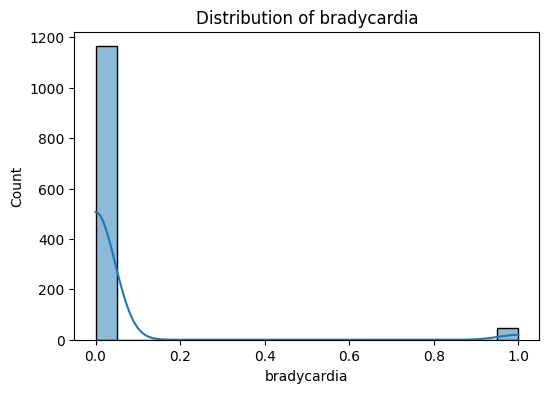

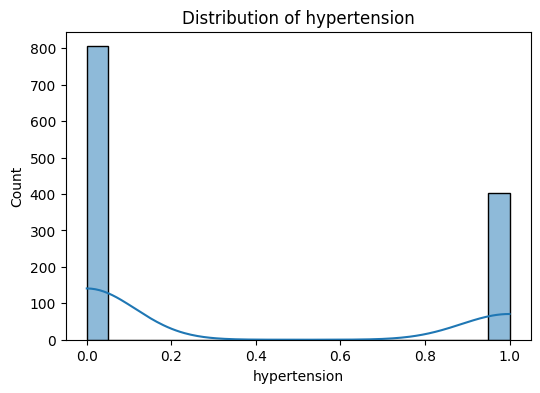

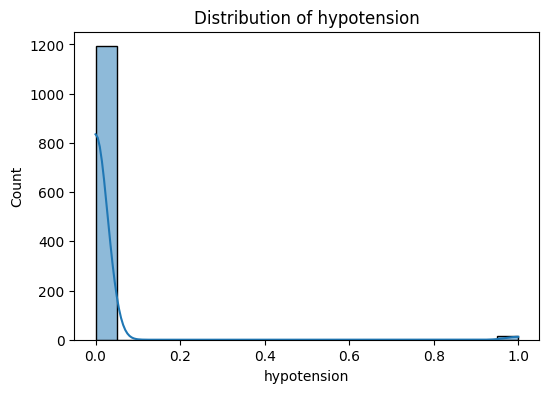

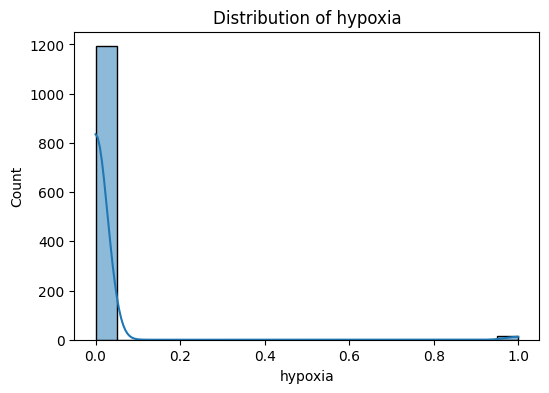

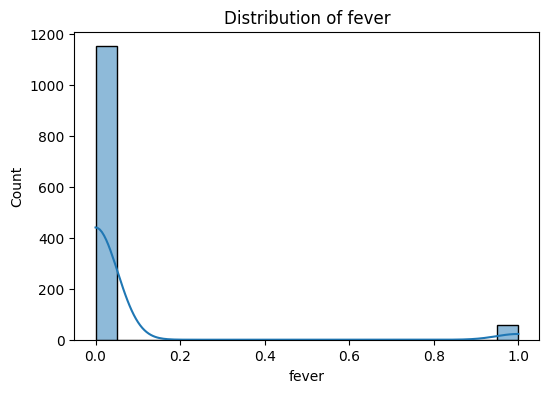

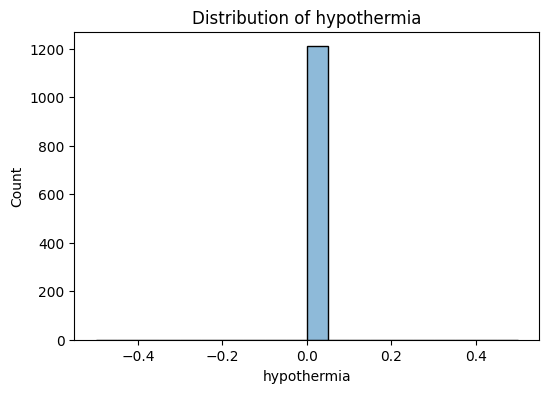

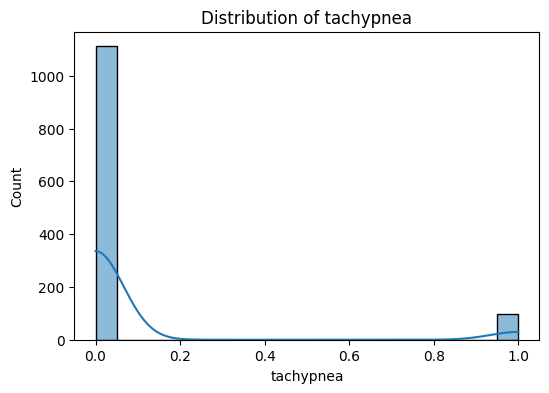

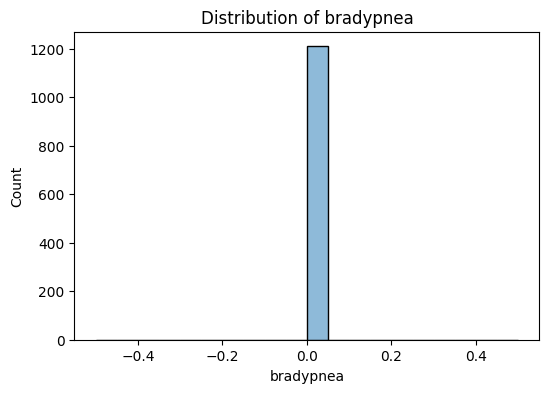


Counts of ktas_expert levels:
ktas_expert
1      5
2    211
3    482
4    442
5     69
Name: count, dtype: int64


C:\Users\areej\AppData\Local\Temp\ipykernel_5936\2230258558.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=ktas_col, data=df, palette='Set2')


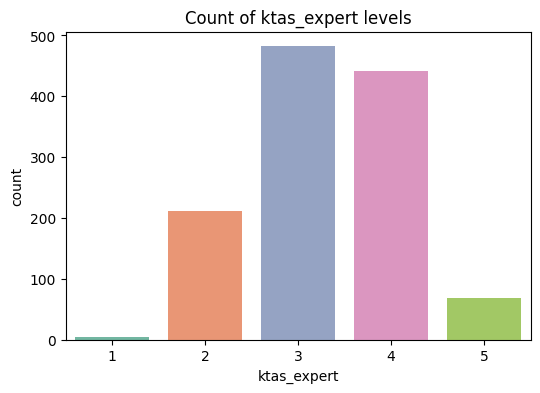


Value counts for chief_complain:


chief_complain
abd pain                71
dizziness               59
dyspnea                 56
fever                   44
ant. chest pain         43
                        ..
abdomen distension       1
behavior change          1
G/W-General weakness     1
Sensory, Decreased       1
orthopnea                1
Name: count, Length: 396, dtype: int64


Value counts for diagnosis_in_ed:


diagnosis_in_ed
Acute gastroenteritis                                                                           49
Headache                                                                                        25
Unspecified abdominal pain                                                                      23
Ischaemic chest pain                                                                            21
Open wound of other parts of head, face                                                         20
                                                                                                ..
Premature rupture of membranes, onset of labor within 24 hours, Unspecified                      1
Alcoholic encephalopathy                                                                         1
Spondylopathy in other infectious and parasitic diseases classified elsewhere, lumbar region     1
Ventricular tachycardia                                                                      


Value counts for age_group:


age_group
senior    500
middle    364
adult     321
teen       24
Name: count, dtype: int64

In [10]:
df = pd.read_excel('cleaned_final.xlsx')

# Display basic info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum())

# --- Summary statistics for numeric columns ---
numeric_cols = df.select_dtypes(include=['int64', 'Int64', 'float64']).columns.tolist()
print("\nNumeric summary statistics:")
display(df[numeric_cols].describe().transpose())

# --- Distribution plots for numeric columns ---
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

# --- Count of KTAS levels ---
ktas_col = 'ktas_expert'  # adjust if needed
if ktas_col in df.columns:
    print(f"\nCounts of {ktas_col} levels:")
    print(df[ktas_col].value_counts().sort_index())
    
    # Bar plot
    plt.figure(figsize=(6,4))
    sns.countplot(x=ktas_col, data=df, palette='Set2')
    plt.title(f'Count of {ktas_col} levels')
    plt.show()

# --- Categorical columns summary ---
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    display(df[col].value_counts())


In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Target column
target = 'ktas_expert'

# Columns to drop from features
# Columns: ['group', 'sex', 'age', 'patients_number_per_hour', 'arrival_mode', 'injury', 'chief_complain', 'mental', 'pain', 'nrs_pain', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation', 'ktas_rn', 'diagnosis_in_ed', 'disposition', 'ktas_expert', 'error_group', 'length_of_stay_min', 'ktas_duration_min', 'mistriage']

drop_cols = [
    target,
    'ktas_rn',       
    'error_group',   
    'mistriage', 
    'length_of_stay_min',
    'ktas_duration_min',
    'patients_number_per_hour',
    'diagnosis_in_ed',
    'disposition']

X = df_clean.drop(columns=drop_cols)
y = df_clean[target]



cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_float = X_train.astype(float)


print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train_float, y_train)
print("After SMOTE, training set shape:", X_train_res.shape)
print("Class distribution after SMOTE:", Counter(y_train_res))

# Scaling for LogisticRegression/SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


Training set shape: (967, 422)
Test set shape: (242, 422)
After SMOTE, training set shape: (1925, 422)
Class distribution after SMOTE: Counter({np.int64(4): 385, np.int64(5): 385, np.int64(2): 385, np.int64(3): 385, np.int64(1): 385})



=== Random Forest ===
Accuracy: 0.6983
Cross-Validation Accuracy: 0.8161 ± 0.0167
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.64      0.55      0.59        42
         3.0       0.70      0.78      0.74        97
         4.0       0.73      0.77      0.75        88
         5.0       1.00      0.14      0.25        14

    accuracy                           0.70       242
   macro avg       0.61      0.45      0.47       242
weighted avg       0.71      0.70      0.69       242



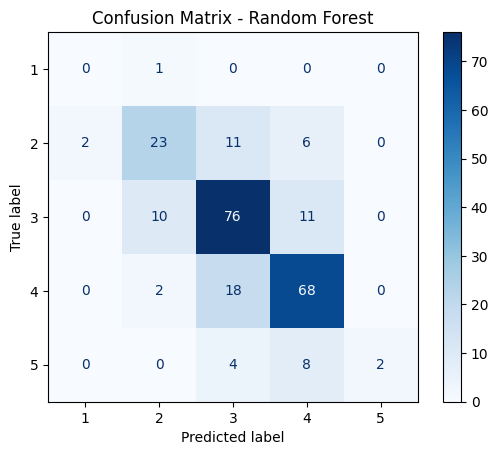


=== Gradient Boosting ===
Accuracy: 0.6860
Cross-Validation Accuracy: 0.8286 ± 0.0184
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.69      0.57      0.62        42
         3.0       0.67      0.74      0.70        97
         4.0       0.70      0.78      0.74        88
         5.0       1.00      0.07      0.13        14

    accuracy                           0.69       242
   macro avg       0.61      0.43      0.44       242
weighted avg       0.70      0.69      0.67       242



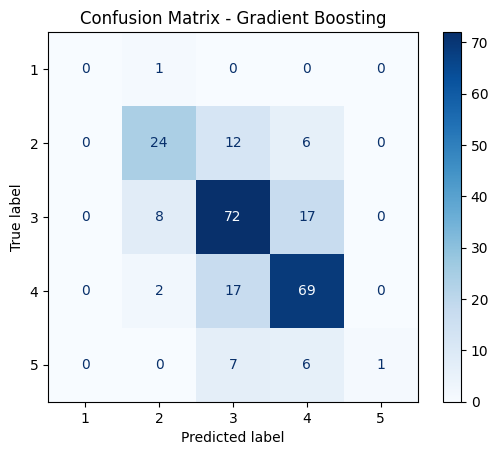


=== XGBoost ===


c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:16:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:16:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:16:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:16:16] WARNING: C:\actio

Accuracy: 0.6860
Cross-Validation Accuracy: 0.8213 ± 0.0216
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.60      0.50      0.55        42
         2.0       0.70      0.73      0.71        97
         3.0       0.71      0.84      0.77        88
         4.0       0.00      0.00      0.00        14

    accuracy                           0.69       242
   macro avg       0.40      0.41      0.41       242
weighted avg       0.64      0.69      0.66       242



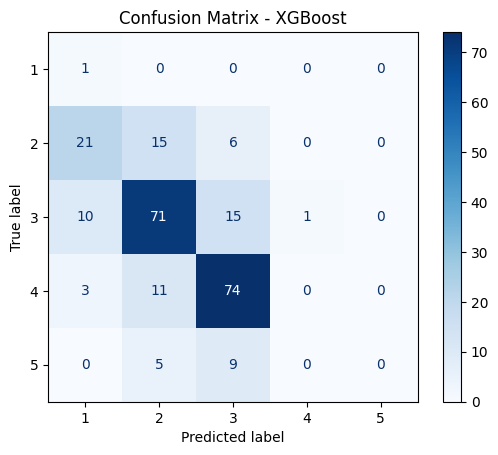


=== Logistic Regression ===
Accuracy: 0.5372
Cross-Validation Accuracy: 0.8197 ± 0.0115
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.36      0.62      0.45        42
         3.0       0.71      0.48      0.58        97
         4.0       0.57      0.62      0.60        88
         5.0       0.50      0.14      0.22        14

    accuracy                           0.54       242
   macro avg       0.43      0.37      0.37       242
weighted avg       0.58      0.54      0.54       242



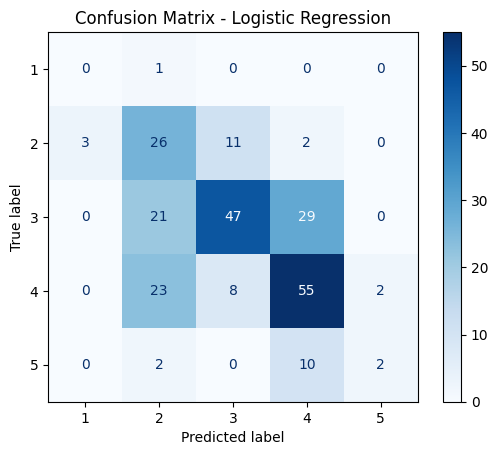


=== Decision Tree ===
Accuracy: 0.6074
Cross-Validation Accuracy: 0.7766 ± 0.0276
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.47      0.40      0.44        42
         3.0       0.59      0.63      0.61        97
         4.0       0.68      0.76      0.72        88
         5.0       0.50      0.14      0.22        14

    accuracy                           0.61       242
   macro avg       0.45      0.39      0.40       242
weighted avg       0.59      0.61      0.59       242



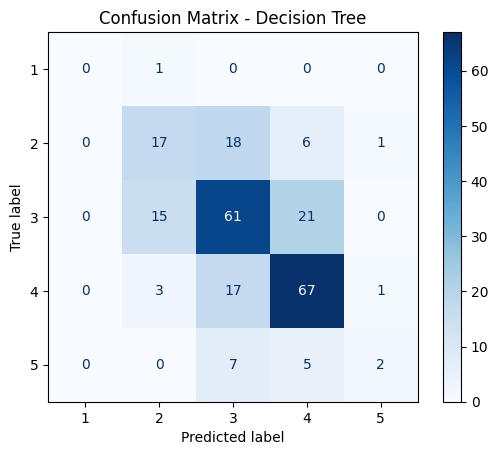


=== Extra Trees ===
Accuracy: 0.6901
Cross-Validation Accuracy: 0.8483 ± 0.0094
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.65      0.57      0.61        42
         3.0       0.71      0.72      0.71        97
         4.0       0.70      0.82      0.75        88
         5.0       1.00      0.07      0.13        14

    accuracy                           0.69       242
   macro avg       0.61      0.44      0.44       242
weighted avg       0.71      0.69      0.67       242



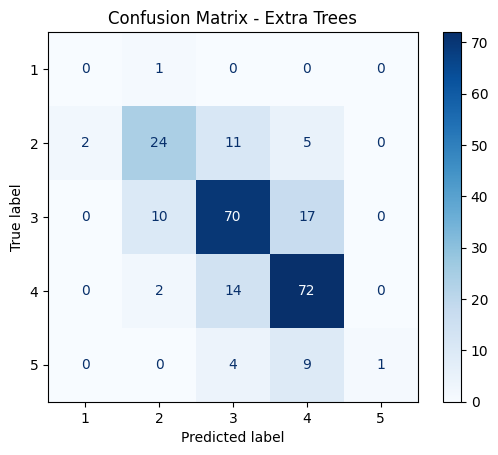


=== SVM ===
Accuracy: 0.4959
Cross-Validation Accuracy: 0.7932 ± 0.0141
              precision    recall  f1-score   support

         1.0       0.20      1.00      0.33         1
         2.0       0.31      0.57      0.40        42
         3.0       0.63      0.58      0.60        97
         4.0       0.60      0.41      0.49        88
         5.0       0.27      0.21      0.24        14

    accuracy                           0.50       242
   macro avg       0.40      0.55      0.41       242
weighted avg       0.54      0.50      0.50       242



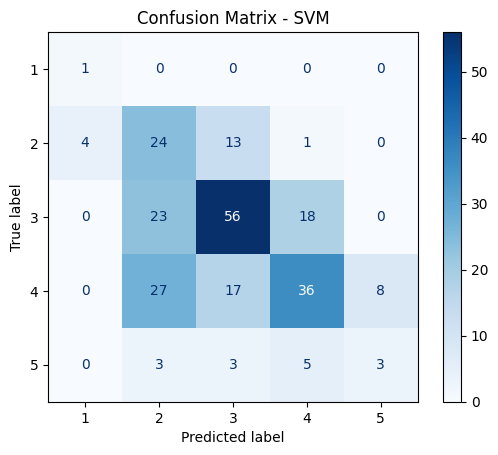


=== KNN ===
Accuracy: 0.4380
Cross-Validation Accuracy: 0.7418 ± 0.0151
              precision    recall  f1-score   support

         1.0       0.04      1.00      0.08         1
         2.0       0.28      0.45      0.35        42
         3.0       0.57      0.54      0.55        97
         4.0       0.62      0.38      0.47        88
         5.0       0.17      0.07      0.10        14

    accuracy                           0.44       242
   macro avg       0.34      0.49      0.31       242
weighted avg       0.51      0.44      0.46       242



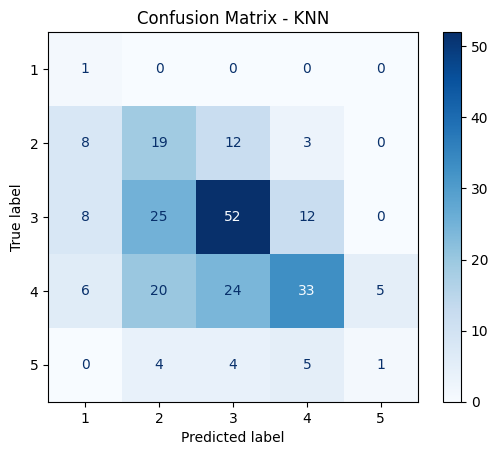

,Model,Accuracy,CV Accuracy
0,Random Forest,0.698347,0.816104
5,Extra Trees,0.690083,0.848312
2,XGBoost,0.685950,0.821299
1,Gradient Boosting,0.685950,0.828571
4,Decision Tree,0.607438,0.776623
3,Logistic Regression,0.537190,0.819740
6,SVM,0.495868,0.793247
7,KNN,0.438017,0.741818


In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score


# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=12, min_samples_split=4, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=500, random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_train_shifted = y_train_res - 1
y_test_shifted = y_test - 1

for name, model in models.items():
    print(f"\n=== {name} ===")
    if name in ["Logistic Regression", "SVM", "KNN"]:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
        y_train_model = y_train_res 
        y_test_model = y_test
    elif name == "XGBoost":
        X_train_model = X_train_res
        X_test_model = X_test
        y_train_model = y_train_shifted 
        y_test_model = y_test_shifted
    else:  
        X_train_model = X_train_res
        X_test_model = X_test
        y_train_model = y_train_res
        y_test_model = y_test

    # Fit model
    model.fit(X_train_model, y_train_model)
    
    # Predict
    y_pred = model.predict(X_test_model)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_model, y_train_model, cv=skf, scoring='accuracy')
    
    # Metrics
    acc = accuracy_score(y_test_model, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(classification_report(y_test_model, y_pred, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.sort(y.unique()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    results.append((name, acc, cv_scores.mean()))


# Train and evaluate models
# for name, model in models.items():
#     print(f"\nTraining {name}...")
#     if name == "XGBoost":
#         model.fit(X_train, y_train_shifted)
#         y_pred = model.predict(X_test)
#         acc = accuracy_score(y_test_shifted, y_pred)
#         print(f"\n{name} Accuracy: {acc:.4f}")
#         print(classification_report(y_test_shifted, y_pred))

#     else:
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         acc = accuracy_score(y_test, y_pred)
#         print(f"\n{name} Accuracy: {acc:.4f}")
#         print(classification_report(y_test, y_pred))
        
    
#     results.append((name, acc))

# Display summary table
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'CV Accuracy']).sort_values(by='Accuracy', ascending=False)
display(results_df)
